# 1. Dataset

## 1.1 Download and clean dataset
The dataset we will be using is the cifar10 dataset. It contains 10 categories of different objects.

We will create a class called Cifar10 which holds all functions we will use for our dataset

In [ ]:
import os, shutil, glob
import numpy as np
import torch, torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [ ]:
class Cifar10():
  def __init__(self, root_dir, img_size, batch_size, imgnet_mean, imgnet_std):
    self.root_dir = root_dir
    self.img_size = img_size
    self.batch_size = batch_size
    # The mean and standard deviation used for training resnet50
    self.imgnet_mean = imgnet_mean
    self.imgnet_std = imgnet_std

  def _get_tfms(self):
    transformations = transforms.Compose([
        transforms.RandomResizedCrop(self.img_size), # Resize the image by cropping random portions of the image
        transforms.ToTensor(),
        transforms.Normalize(mean=self.imgnet_mean, std=self.imgnet_std) # Set the rgb color channels of the images mean and std to the resnet50 mean and std
    ])
    return transformations

  def get_dataset(self):
    transformations = self._get_tfms()
    train_ds = datasets.CIFAR10(root=self.root_dir, train=True, transform=transformations, download=True)
    test_ds = datasets.CIFAR10(root=self.root_dir, train=False, transform=transformations)
    labels = train_ds.classes

    return train_ds, test_ds, labels
  
  def load_dataset(self, train_ds, test_ds):
    train_dl = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True)
    test_dl = DataLoader(test_ds, batch_size=self.batch_size, shuffle=False)
    return train_dl, test_dl

In [ ]:
IMG_SIZE = 224
BATCH_SIZE = 256
DATA_DIR = "dataset"
IMGNET_MEAN = [0.485, 0.456, 0.406]
IMGNET_STD = [0.229, 0.224, 0.225]

In [ ]:
cifar = Cifar10(DATA_DIR, IMG_SIZE, BATCH_SIZE, IMGNET_MEAN, IMGNET_STD)

In [ ]:
train_ds, test_ds, labels = cifar.get_dataset()

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting dataset/cifar-10-python.tar.gz to dataset


In [ ]:
train_dl, test_dl = cifar.load_dataset(train_ds, test_ds)

In [ ]:
len(train_ds), len(test_ds), len(labels)

(50000, 10000, 10)

In [ ]:
len(train_dl), labels

(196,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

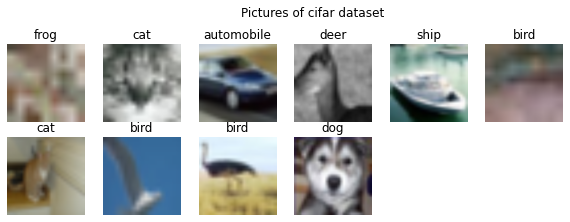

In [ ]:
X_train, y_train = next(iter(train_dl))

figure = plt.figure(figsize=(10,10))
figure.tight_layout()

title_ax = figure.add_axes([0.5, 0.9, 0.1, 0.01])
title_ax.set_axis_off()

for i in range(10):
  plt.subplot(6,6,i+1)
  X_train_T = X_train[i].numpy().transpose((1, 2, 0))  # Transpose dimensions so that the color channels are at the end rather than at the start
  X_train_T = IMGNET_STD * X_train_T + IMGNET_MEAN
  X_train_T = np.clip(X_train_T, 0, 1)
  plt.imshow(X_train_T)
  plt.title(labels[y_train[i].item()])
  plt.axis("off")

title_ax.set_title("Pictures of cifar dataset")
plt.show()


# 2. Neural Network

In [10]:
from torchvision import models
from torch import nn, optim

## 2.1 Create Network class
We create a Network class which holds all the functions we will use to train and evaluate our model

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
class Network():
  def __init__(self, epochs, train_dl, test_dl, num_labels):
    self.epochs = epochs
    self.train_dl = train_dl
    self.test_dl = test_dl
    self.num_labels = num_labels

  def create_resnet50_model(self):
    model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
    for parameter in model.parameters():
      parameter.requires_grad = False
    model.fc = nn.Linear(model.fc.in_features, self.num_labels)

    model = model.to(device)

    return model
  
  def evaluate_model(self, model, criterion):
    n_correct = 0
    n_total = 0
    predictions = []
    running_loss = 0.0
    
    # Loop over every batch
    for images, labels in self.test_dl:
      images, labels = images.to(device), labels.to(device) # Send to GPU

      output = model(images)
      loss = criterion(output, labels)
      running_loss += loss.item()

      # Accuracy
      _, y_pred = torch.max(output, 1)
      predictions.append(y_pred)
      n_correct += (y_pred == labels).sum().item()
      n_total += labels.size(0)

    accuracy = n_correct / n_total
    
    print(f"Test accuracy: {accuracy}%, Test loss: {running_loss / n_total}")

    predictions = torch.cat(predictions, dim=0)
    return n_correct, y_pred, predictions

  def train_model(self, criterion, optimizer, model):
    n_correct = 0
    n_total = 0
    predictions = []
    running_loss = 0.0
    model.train() # Set to training mode

    for epoch in range(self.epochs):
      print(f"-------- \nEpoch: {epoch+1}/{self.epochs}")
      running_loss = 0.0
      for images, labels in self.train_dl:
        images, labels = images.to(device), labels.to(device) # Send to GPU

        optimizer.zero_grad() # Zero out the gradients to avoid tracking unnecessary information
        
        output = model(images)

        loss = criterion(output, labels)
        loss.backward() # Compute backpropogation

        optimizer.step() # Use gradient descent to update weights

        # Get accuracy on training
        _, y_pred = torch.max(output, 1)
        predictions.append(y_pred)
        n_correct += (y_pred == labels).sum().item()
        n_total += labels.size(0)

        running_loss += loss.item()
      
      # Print loss and accuracy
      print(f"Train accuracy: {n_correct / n_total}, Train Loss: {running_loss / len(self.train_dl)}")
      self.evaluate_model(model, criterion)

    print("Finished training!")

  
  def visualize_predictions(self, predictions, num_examples_to_show):
    X_test, y_test = next(iter(self.test_dl))

    figure = plt.figure(figsize=(15,15))
    figure.tight_layout()

    title_ax = figure.add_axes([0.5, 0.9, 0.1, 0.03])
    title_ax.set_axis_off()

    for i in range(num_examples_to_show):
      plt.subplot(7,7,i+1)
      X_test_T = X_test[i].numpy().transpose((1, 2, 0))
      X_test_T = IMGNET_STD * X_test_T + IMGNET_MEAN
      X_test_T = np.clip(X_test_T, 0, 1)
      plt.imshow(X_test_T)
      plt.title(f"{labels[predictions[i].item()]} | {labels[y_test[i].item()]}")
      plt.axis("off")

    title_ax.set_title("format: {predicted_label} | {actual_label}")
    figure.subplots_adjust(hspace=0.5, wspace=1)
    plt.show()

## 2.2 Train model

In [13]:
epochs = 30
network = Network(epochs, train_dl, test_dl, len(labels))

In [14]:
model = network.create_resnet50_model()

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [15]:
lr = 0.001
momentum = 0.9

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum)

In [16]:
torch.cuda.empty_cache()

network.train_model(criterion=criterion, optimizer=optimizer, model=model)

-------- 
Epoch: 1/30
Train accuracy: 0.32576, Train Loss: 2.1129178295330124
Test accuracy: 0.4306%, Test loss: 0.007793459320068359
-------- 
Epoch: 2/30
Train accuracy: 0.39382, Train Loss: 1.8656303760956745
Test accuracy: 0.477%, Test loss: 0.007185623788833619
-------- 
Epoch: 3/30
Train accuracy: 0.42667333333333335, Train Loss: 1.7529917018754142
Test accuracy: 0.4994%, Test loss: 0.006850721335411072
-------- 
Epoch: 4/30
Train accuracy: 0.445835, Train Loss: 1.6923712601467056
Test accuracy: 0.5087%, Test loss: 0.006687004125118256
-------- 
Epoch: 5/30
Train accuracy: 0.460304, Train Loss: 1.6501844397612981
Test accuracy: 0.5178%, Test loss: 0.006544153869152069
-------- 
Epoch: 6/30
Train accuracy: 0.4709466666666667, Train Loss: 1.6211903697373915
Test accuracy: 0.5245%, Test loss: 0.006433256280422211
-------- 
Epoch: 7/30
Train accuracy: 0.47994857142857145, Train Loss: 1.59458455200098
Test accuracy: 0.5295%, Test loss: 0.006402920985221863
-------- 
Epoch: 8/30
Train 

In [21]:
n_correct, y_pred, predictions = network.evaluate_model(model, criterion)

Test accuracy: 0.5818%, Test loss: 0.005812804770469666


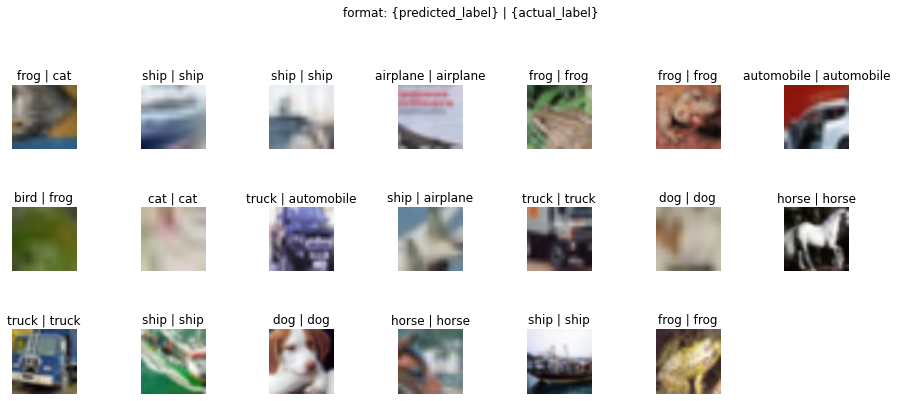

In [23]:
network.visualize_predictions(predictions, 20)